EDA questions:

Condo and pool? - filter for both to see how many have both

How does having a pool affect property values?

Does garage type matter? Is just T/F enough or do we need number of spaces?

Do we want to include buying multi-family? 

Do we want to include the manufactured properties? They seem to be mostly mobile homes, but there are some single family homes mixed in.

Need to look at floor count

filtering out outliers in price

how has the sale price changed over the course of the year

drop propertyType apartment, Multi-Family, Manufactured, maybe/probably Land, probably Townhouse
use isin to get just 
data = data[data['propertyType'].isin(['Single Family','Condo'])]

entering 1 for nulls in floor count?

In [1314]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [1315]:
# Loading data from SQLite to pandas

path_to_db = '/workspaces/mds8-final-project-bmh/data/raw/rentcast_FL.db'
conn = sqlite3.connect(path_to_db)
query = """SELECT * FROM properties"""
data = pd.read_sql(query, conn)
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,fireplace,floorCount,foundationType,garage,garageSpaces,garageType,pool,roomCount,unitCount,viewType
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2.0,...,0,2.0,None,0,NaN,None,True,NaN,1.0,Water
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,0,1.0,None,1,4.0,Garage,False,NaN,1.0,None
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,0,NaN,None,0,NaN,None,False,NaN,NaN,None


In [1316]:
data.shape

(145617, 35)

In [1317]:
# Confirming no duplicates (dropped before converting original csv to database)

data.duplicated().any()

np.False_

In [1318]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  zoning            86564 non-null   object 
 16  lastSaleDate      14

In [1319]:
# Dropping columns with few values

drop_cols = ['zoning','hoa','architectureType','coolingType','heatingType','garageSpaces','garageType','roomCount','foundationType','exteriorType'] 
# initially dropped viewType, but saving it for now because of later EDA concerns

data = data.drop(drop_cols, axis=1)
data.shape

(145617, 25)

In [1320]:
# Converting values as needed

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  lastSaleDate      145617 non-null  object 
 16  lastSalePrice     14

In [1321]:
data['zipCode'] = data['zipCode'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145617 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  object 
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  lastSaleDate      145617 non-null  object 
 16  lastSalePrice     14

In [1322]:
# Why are there so many nulls in bedroom and bathroom?

data[(data['bedrooms'].isna()) & (data['propertyType'] == 'Condo')]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
11,"4250-Biscayne-Blvd,-Apt-510,-Miami,-FL-33137","4250 Biscayne Blvd, Apt 510, Miami, FL 33137",Miami,FL,33137,Miami-Dade,25.815609,-80.189226,Condo,NaN,...,2024-03-12T00:00:00.000Z,300000.0,0,0,0,NaN,0,False,NaN,None
255,"1621-Gulf-Blvd,-Apt-705,-Clearwater-Beach,-FL-...","1621 Gulf Blvd, Apt 705, Clearwater Beach, FL ...",Clearwater Beach,FL,33767,Pinellas,27.938601,-82.838433,Condo,NaN,...,2024-03-12T00:00:00.000Z,575000.0,1,1,0,1.0,1,True,1.0,Water
320,"505-Mandalay-Ave,-Apt-66,-Clearwater-Beach,-FL...","505 Mandalay Ave, Apt 66, Clearwater Beach, FL...",Clearwater Beach,FL,33767,Pinellas,27.982908,-82.824513,Condo,NaN,...,2024-03-12T00:00:00.000Z,900000.0,0,0,0,3.0,1,True,1.0,None
465,"999-Fort-Pickens-Rd,-Apt-501,-Gulf-Breeze,-FL-...","999 Fort Pickens Rd, Apt 501, Gulf Breeze, FL ...",Gulf Breeze,FL,32561,Escambia,30.327714,-87.163409,Condo,NaN,...,2024-03-12T00:00:00.000Z,455000.0,1,1,0,1.0,0,False,1.0,None
577,"2900-45th-St-S,-Apt-1,-Gulfport,-FL-33711","2900 45th St S, Apt 1, Gulfport, FL 33711",Gulfport,FL,33711,Pinellas,27.741663,-82.693932,Condo,NaN,...,2024-03-12T00:00:00.000Z,225000.0,1,1,0,1.0,0,True,1.0,Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145333,"6500-Valen-Way,-Apt-301,-Naples,-FL-34108","6500 Valen Way, Apt 301, Naples, FL 34108",Naples,FL,34108,Collier,26.227702,-81.808722,Condo,NaN,...,2024-06-26T00:00:00.000Z,950000.0,0,0,0,NaN,0,False,NaN,None
145338,"9138-Chula-Vista-St,-Unit-12702,-Naples,-FL-34113","9138 Chula Vista St, Unit 12702, Naples, FL 34113",Naples,FL,34113,Collier,26.071624,-81.694981,Condo,NaN,...,2024-06-26T00:00:00.000Z,480000.0,0,0,0,NaN,0,False,NaN,None
145440,"414-School-Rd,-Apt-96,-Indian-Harbour-Beach,-F...","414 School Rd, Apt 96, Indian Harbour Beach, F...",Indian Harbour Beach,FL,32937,Brevard,28.149827,-80.590093,Condo,NaN,...,2024-06-26T00:00:00.000Z,228000.0,1,1,0,NaN,0,False,1.0,None
145487,"4084-Northlight-Dr,-Naples,-FL-34112","4084 Northlight Dr, Naples, FL 34112",Naples,FL,34112,Collier,26.137556,-81.758128,Condo,NaN,...,2024-06-26T00:00:00.000Z,272250.0,0,0,0,NaN,0,False,1.0,None


In [1323]:
# I suspected condos with null for bedrooms would be studio apartments, but checking these on Zillow shows no pattern.

In [1324]:
data[(data['bedrooms'].isna()) & (data['bathrooms'].isna())]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
86,"7101-Carmel-Dr,-Tallahassee,-FL-32309","7101 Carmel Dr, Tallahassee, FL 32309",Tallahassee,FL,32309,Leon,30.554501,-84.189851,Single Family,NaN,...,2024-03-12T00:00:00.000Z,1450000.0,1,0,0,1.0,1,False,1.0,None
147,"9000-Us-Hwy,-192-Lot-22,-Clermont,-FL-34714","9000 Us Hwy, 192 Lot 22, Clermont, FL 34714",Clermont,FL,34714,Polk,28.346810,-81.657906,Land,NaN,...,2024-03-12T00:00:00.000Z,54000.0,0,0,0,NaN,0,False,NaN,None
175,"971-Mendel-Ave,-Marco-Island,-FL-34145","971 Mendel Ave, Marco Island, FL 34145",Marco Island,FL,34145,Collier,25.917499,-81.724744,Single Family,NaN,...,2024-03-12T00:00:00.000Z,999999.0,0,0,0,1.0,0,True,1.0,None
196,"110-Nw-53rd-St,-Deerfield-Beach,-FL-33064","110 Nw 53rd St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.294703,-80.123712,Manufactured,NaN,...,2024-03-12T00:00:00.000Z,150000.0,0,0,0,1.0,0,False,1.0,None
197,"222-Nw-54th-St,-Deerfield-Beach,-FL-33064","222 Nw 54th St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.296940,-80.125560,Manufactured,NaN,...,2024-03-12T00:00:00.000Z,149000.0,0,0,0,1.0,0,False,1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145521,"2950-Glades-Cir,-Ste-13,-Weston,-FL-33327","2950 Glades Cir, Ste 13, Weston, FL 33327",Weston,FL,33327,Broward,26.140168,-80.423344,None,NaN,...,2024-06-26T00:00:00.000Z,585000.0,0,0,0,NaN,0,False,NaN,None
145533,"1333-E-Main-St,-Lakeland,-FL-33801","1333 E Main St, Lakeland, FL 33801",Lakeland,FL,33801,Polk,28.043833,-81.937577,None,NaN,...,2024-06-26T00:00:00.000Z,425000.0,0,0,0,NaN,0,False,NaN,None
145560,"520-Whitney-Ave,-Ste-B3,-Lantana,-FL-33462","520 Whitney Ave, Ste B3, Lantana, FL 33462",Lantana,FL,33462,Palm Beach,26.591424,-80.055803,None,NaN,...,2024-06-26T00:00:00.000Z,60000.0,0,0,0,NaN,0,False,NaN,None
145571,"624-Monroe-Ave,-Apt-401,-Cape-Canaveral,-FL-32920","624 Monroe Ave, Apt 401, Cape Canaveral, FL 32920",Cape Canaveral,FL,32920,Brevard,28.388759,-80.597482,Condo,NaN,...,2024-06-26T00:00:00.000Z,725000.0,0,0,0,NaN,0,False,1.0,None


In [1325]:
# Dropping rows with nulls for bedrooms, bathrooms, or propertyType--no apparent pattern from Zillow checks

data = data.dropna(subset=['bedrooms','bathrooms','propertyType'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126250 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                126250 non-null  object 
 1   formattedAddress  126250 non-null  object 
 2   city              126250 non-null  object 
 3   state             126250 non-null  object 
 4   zipCode           126250 non-null  object 
 5   county            126179 non-null  object 
 6   latitude          126250 non-null  float64
 7   longitude         126250 non-null  float64
 8   propertyType      126250 non-null  object 
 9   bedrooms          126250 non-null  float64
 10  bathrooms         126250 non-null  float64
 11  squareFootage     125988 non-null  float64
 12  lotSize           113262 non-null  float64
 13  yearBuilt         122787 non-null  float64
 14  subdivision       109225 non-null  object 
 15  lastSaleDate      126250 non-null  object 
 16  lastSalePrice     126230 

In [1326]:
# What are the properties with null for square footage?

data[data['squareFootage'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
2553,"4300-Sw-194th-Ave,-Ocala,-FL-34432","4300 Sw 194th Ave, Ocala, FL 34432",Ocala,FL,34432,Marion,29.145551,-82.441040,Manufactured,2.0,...,2024-03-13T00:00:00.000Z,70000.0,0,0,0,NaN,0,False,NaN,None
2680,"2019-Detroit-Dr,-Unit-2019,-Labelle,-FL-33935","2019 Detroit Dr, Unit 2019, Labelle, FL 33935",Labelle,FL,33935,Hendry,26.754504,-81.409879,Single Family,3.0,...,2024-03-13T00:00:00.000Z,300286.0,0,0,0,NaN,0,False,NaN,None
6227,"11943-Sw-241st-St,-Homestead,-FL-33032","11943 Sw 241st St, Homestead, FL 33032",Homestead,FL,33032,Miami-Dade,25.543721,-80.385247,Land,3.0,...,2024-03-18T00:00:00.000Z,620000.0,0,0,0,NaN,0,False,NaN,None
6386,"120-Lakeridge-Dr,-Panama-City,-FL-32405","120 Lakeridge Dr, Panama City, FL 32405",Panama City,FL,32405,Bay,30.211556,-85.656478,Land,3.0,...,2024-03-18T00:00:00.000Z,98000.0,0,0,0,1.0,0,False,NaN,None
7091,"2285-Se-7th-St,-Pompano-Beach,-FL-33062","2285 Se 7th St, Pompano Beach, FL 33062",Pompano Beach,FL,33062,Broward,26.225343,-80.100922,Single Family,3.0,...,2024-03-19T00:00:00.000Z,960000.0,0,0,0,NaN,0,False,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144050,"3908-Southern-Vista-Loop,-Saint-Cloud,-FL-34772","3908 Southern Vista Loop, Saint Cloud, FL 34772",Saint Cloud,FL,34772,Osceola,28.222399,-81.269892,Single Family,4.0,...,2024-06-25T00:00:00.000Z,425000.0,0,0,0,NaN,0,False,NaN,None
144084,"7239-Mahogany-Run-Dr,-Jacksonville,-FL-32244","7239 Mahogany Run Dr, Jacksonville, FL 32244",Jacksonville,FL,32244,Duval,30.215261,-81.762997,Land,4.0,...,2024-06-25T00:00:00.000Z,394900.0,0,0,0,NaN,0,False,NaN,None
144271,"630-Lightsey-Crossing-Ln,-Saint-Augustine,-FL-...","630 Lightsey Crossing Ln, Saint Augustine, FL ...",Saint Augustine,FL,32084,Saint Johns,29.862384,-81.365361,Single Family,4.0,...,2024-06-25T00:00:00.000Z,427000.0,0,0,0,NaN,0,False,NaN,None
144536,"13457-Sw-60th-Avenue-Rd,-Ocala,-FL-34473","13457 Sw 60th Avenue Rd, Ocala, FL 34473",Ocala,FL,34473,Marion,29.026587,-82.220585,Land,3.0,...,2024-06-25T00:00:00.000Z,37100.0,0,1,0,1.0,1,False,NaN,None


In [1327]:
# No pattern--dropping these rows
data = data.dropna(subset=['squareFootage'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125988 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                125988 non-null  object 
 1   formattedAddress  125988 non-null  object 
 2   city              125988 non-null  object 
 3   state             125988 non-null  object 
 4   zipCode           125988 non-null  object 
 5   county            125920 non-null  object 
 6   latitude          125988 non-null  float64
 7   longitude         125988 non-null  float64
 8   propertyType      125988 non-null  object 
 9   bedrooms          125988 non-null  float64
 10  bathrooms         125988 non-null  float64
 11  squareFootage     125988 non-null  float64
 12  lotSize           113094 non-null  float64
 13  yearBuilt         122606 non-null  float64
 14  subdivision       109156 non-null  object 
 15  lastSaleDate      125988 non-null  object 
 16  lastSalePrice     125968 

In [1328]:
# Nulls for yearBuilt

data[data['yearBuilt'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
409,"2704-Ne-7th-Pl,-Cape-Coral,-FL-33909","2704 Ne 7th Pl, Cape Coral, FL 33909",Cape Coral,FL,33909,Lee,26.701938,-81.958214,Single Family,4.0,...,2024-03-12T00:00:00.000Z,23400.0,0,0,0,NaN,0,False,NaN,None
451,"24-Palermo-Ln,-Palm-Coast,-FL-32164","24 Palermo Ln, Palm Coast, FL 32164",Palm Coast,FL,32164,Flagler,29.535680,-81.223645,Single Family,4.0,...,2024-03-12T00:00:00.000Z,54000.0,0,0,0,NaN,0,False,NaN,None
461,"3623-Woodmont-Dr,-Parrish,-FL-34219","3623 Woodmont Dr, Parrish, FL 34219",Parrish,FL,34219,Manatee,27.546984,-82.458032,Single Family,3.0,...,2024-03-12T00:00:00.000Z,405000.0,0,0,0,NaN,0,False,NaN,None
550,"4129-Acoma-Dr,-Ormond-Beach,-FL-32174","4129 Acoma Dr, Ormond Beach, FL 32174",Ormond Beach,FL,32174,Volusia,29.410674,-81.150928,Condo,5.0,...,2024-03-12T00:00:00.000Z,404400.0,0,0,0,NaN,0,False,NaN,None
899,"5796-Arboretum-St,-Saint-Cloud,-FL-34771","5796 Arboretum St, Saint Cloud, FL 34771",Saint Cloud,FL,34771,Osceola,28.302701,-81.207161,Land,5.0,...,2024-03-12T00:00:00.000Z,476990.0,0,0,0,NaN,0,False,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145597,"38120-Shale-Stone-Ct,-Zephyrhills,-FL-33540","38120 Shale Stone Ct, Zephyrhills, FL 33540",Zephyrhills,FL,33540,Pasco,28.197722,-82.186716,Single Family,5.0,...,2024-06-26T00:00:00.000Z,543600.0,0,0,0,NaN,0,False,NaN,None
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.665775,-82.482020,Single Family,3.0,...,2024-06-26T00:00:00.000Z,387790.0,0,0,0,NaN,0,False,NaN,None
145600,"111-Charmer-Trce,-Saint-Augustine,-FL-32092","111 Charmer Trce, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,29.918559,-81.517488,Single Family,3.0,...,2024-06-26T00:00:00.000Z,425000.0,0,0,0,NaN,0,False,NaN,None
145613,"249-Seaforth-Dr,-Saint-Augustine,-FL-32092","249 Seaforth Dr, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,30.017957,-81.567897,Single Family,4.0,...,2024-06-26T00:00:00.000Z,499700.0,0,0,0,NaN,0,False,NaN,None


In [1329]:
# This subset of nulls for yearBuilt all appear to be new builds--filling this with 2024

data['yearBuilt'] = data['yearBuilt'].fillna(2024)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125988 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                125988 non-null  object 
 1   formattedAddress  125988 non-null  object 
 2   city              125988 non-null  object 
 3   state             125988 non-null  object 
 4   zipCode           125988 non-null  object 
 5   county            125920 non-null  object 
 6   latitude          125988 non-null  float64
 7   longitude         125988 non-null  float64
 8   propertyType      125988 non-null  object 
 9   bedrooms          125988 non-null  float64
 10  bathrooms         125988 non-null  float64
 11  squareFootage     125988 non-null  float64
 12  lotSize           113094 non-null  float64
 13  yearBuilt         125988 non-null  float64
 14  subdivision       109156 non-null  object 
 15  lastSaleDate      125988 non-null  object 
 16  lastSalePrice     125968 

In [1330]:
# Nulls for lotSize

data[data['lotSize'].isna()]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
14,"94-Upminster-D,-Deerfield-Beach,-FL-33442","94 Upminster D, Deerfield Beach, FL 33442",Deerfield Beach,FL,33442,Broward,26.312560,-80.128489,Condo,2.0,...,2024-03-12T00:00:00.000Z,150000.0,0,0,0,NaN,0,False,1.0,None
24,"1300-S-Miami-Ave,-Unit-1508,-Miami,-FL-33130","1300 S Miami Ave, Unit 1508, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.761104,-80.193724,Condo,1.0,...,2024-03-12T00:00:00.000Z,535000.0,0,0,0,NaN,0,False,NaN,None
46,"7240-Nw-114th-Ave,-Apt-102,-Doral,-FL-33178","7240 Nw 114th Ave, Apt 102, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.839086,-80.382484,Condo,1.0,...,2024-03-12T00:00:00.000Z,260000.0,0,0,0,NaN,0,False,1.0,None
59,"2908-Se-17th-Ave,-Unit-101,-Homestead,-FL-33035","2908 Se 17th Ave, Unit 101, Homestead, FL 33035",Homestead,FL,33035,Miami-Dade,25.444631,-80.453645,Condo,3.0,...,2024-03-12T00:00:00.000Z,245000.0,0,0,0,1.0,0,False,NaN,None
70,"3000-S-Ocean-Dr,-Apt-1200,-Hollywood,-FL-33019","3000 S Ocean Dr, Apt 1200, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.994751,-80.117511,Condo,2.0,...,2024-03-12T00:00:00.000Z,490000.0,0,0,0,NaN,0,False,1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145539,"408-Ketch-Way,-Nokomis,-FL-34275","408 Ketch Way, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.127408,-82.460810,Single Family,2.0,...,2024-06-26T00:00:00.000Z,395000.0,1,1,0,1.0,1,False,1.0,Average
145589,"8635-Midnight-Pass-Rd,-Apt-C207,-Sarasota,-FL-...","8635 Midnight Pass Rd, Apt C207, Sarasota, FL ...",Sarasota,FL,34242,Sarasota,27.225514,-82.517908,Condo,2.0,...,2024-06-26T00:00:00.000Z,550000.0,1,1,0,1.0,1,False,1.0,Water
145599,"1315-Nw-132nd-Cir,-Newberry,-FL-32669","1315 Nw 132nd Cir, Newberry, FL 32669",Newberry,FL,32669,Alachua,29.665775,-82.482020,Single Family,3.0,...,2024-06-26T00:00:00.000Z,387790.0,0,0,0,NaN,0,False,NaN,None
145600,"111-Charmer-Trce,-Saint-Augustine,-FL-32092","111 Charmer Trce, Saint Augustine, FL 32092",Saint Augustine,FL,32092,Saint Johns,29.918559,-81.517488,Single Family,3.0,...,2024-06-26T00:00:00.000Z,425000.0,0,0,0,NaN,0,False,NaN,None


In [1331]:
# No pattern--dropping nulls for lotSize

data = data.dropna(subset=['lotSize'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113094 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                113094 non-null  object 
 1   formattedAddress  113094 non-null  object 
 2   city              113094 non-null  object 
 3   state             113094 non-null  object 
 4   zipCode           113094 non-null  object 
 5   county            113051 non-null  object 
 6   latitude          113094 non-null  float64
 7   longitude         113094 non-null  float64
 8   propertyType      113094 non-null  object 
 9   bedrooms          113094 non-null  float64
 10  bathrooms         113094 non-null  float64
 11  squareFootage     113094 non-null  float64
 12  lotSize           113094 non-null  float64
 13  yearBuilt         113094 non-null  float64
 14  subdivision       99389 non-null   object 
 15  lastSaleDate      113094 non-null  object 
 16  lastSalePrice     113076 

In [1332]:
# Filling nulls in floor count with 1

data['floorCount'] = data['floorCount'].fillna(1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 113094 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                113094 non-null  object 
 1   formattedAddress  113094 non-null  object 
 2   city              113094 non-null  object 
 3   state             113094 non-null  object 
 4   zipCode           113094 non-null  object 
 5   county            113051 non-null  object 
 6   latitude          113094 non-null  float64
 7   longitude         113094 non-null  float64
 8   propertyType      113094 non-null  object 
 9   bedrooms          113094 non-null  float64
 10  bathrooms         113094 non-null  float64
 11  squareFootage     113094 non-null  float64
 12  lotSize           113094 non-null  float64
 13  yearBuilt         113094 non-null  float64
 14  subdivision       99389 non-null   object 
 15  lastSaleDate      113094 non-null  object 
 16  lastSalePrice     113076 

In [1333]:
# Dropping rows with sale price missing

data = data.dropna(subset=['lastSalePrice'])

In [1334]:
# Converting floats to int

cols_to_int = ['bedrooms','bathrooms','squareFootage','lotSize','yearBuilt','lastSalePrice','floorCount']

data[cols_to_int] = data[cols_to_int].astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113076 entries, 0 to 145616
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                113076 non-null  object 
 1   formattedAddress  113076 non-null  object 
 2   city              113076 non-null  object 
 3   state             113076 non-null  object 
 4   zipCode           113076 non-null  object 
 5   county            113033 non-null  object 
 6   latitude          113076 non-null  float64
 7   longitude         113076 non-null  float64
 8   propertyType      113076 non-null  object 
 9   bedrooms          113076 non-null  int64  
 10  bathrooms         113076 non-null  int64  
 11  squareFootage     113076 non-null  int64  
 12  lotSize           113076 non-null  int64  
 13  yearBuilt         113076 non-null  int64  
 14  subdivision       99376 non-null   object 
 15  lastSaleDate      113076 non-null  object 
 16  lastSalePrice     113076 

In [1335]:
# How has sale price changed over the course of the year? 

In [1336]:
# Investigating the lot size column with condos

condo_lots = data[data['propertyType'] == 'Condo']['lotSize']
condo_lots.head()

3       951
4     43560
18    43560
21     8132
25     5622
Name: lotSize, dtype: int64

In [1337]:
condo_lots.describe()

count    1.072200e+04
mean     1.863603e+05
std      1.620961e+06
min      1.000000e+00
25%      1.310000e+03
50%      1.162900e+04
75%      4.356000e+04
max      1.000000e+08
Name: lotSize, dtype: float64

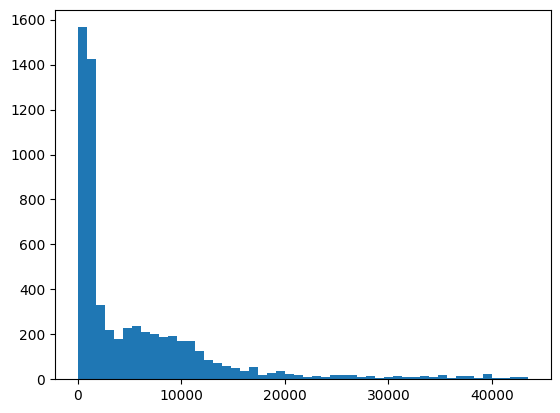

In [1338]:
# Histogram of listed lot sizes with upper quartile as upper range

plt.hist(condo_lots.dropna(), bins=50, range=(1,43500))
plt.show()

In [1339]:
# Looking at upper outliers

condos = data[data['propertyType'] == 'Condo']

condos[condos['lotSize'] >= 10000000.0]


,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
625,"3628-Muirfield-Ct,-New-Port-Richey,-FL-34655","3628 Muirfield Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.211985,-82.664961,Condo,2,...,2024-03-12T00:00:00.000Z,324900,1,1,0,1,1,False,1.0,None
15216,"3445-Niblick-Ct,-New-Port-Richey,-FL-34655","3445 Niblick Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.209507,-82.664333,Condo,2,...,2024-03-27T00:00:00.000Z,220000,1,1,0,1,1,False,1.0,None
20123,"5973-Terrace-Park-Dr-N,-Unit-209,-Saint-Peters...","5973 Terrace Park Dr N, Unit 209, Saint Peters...",Saint Petersburg,FL,33709,Pinellas,27.826396,-82.746076,Condo,2,...,2024-04-01T00:00:00.000Z,136000,1,1,0,1,1,False,1.0,Average
29161,"3734-River-Oaks-Ct,-New-Port-Richey,-FL-34655","3734 River Oaks Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.213333,-82.665034,Condo,2,...,2024-04-09T00:00:00.000Z,225000,1,1,0,1,1,False,1.0,None
32126,"271-Sapphire-Lake-Dr,-Unit-101,-Bradenton,-FL-...","271 Sapphire Lake Dr, Unit 101, Bradenton, FL ...",Bradenton,FL,34209,Manatee,27.504514,-82.682463,Condo,3,...,2024-04-11T00:00:00.000Z,409900,1,1,0,1,1,False,1.0,None
38623,"3654-Trophy-Blvd,-New-Port-Richey,-FL-34655","3654 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.212197,-82.656730,Condo,2,...,2024-04-18T00:00:00.000Z,190000,1,1,0,1,1,0,1.0,None
39517,"9617-Midiron-Ct,-New-Port-Richey,-FL-34655","9617 Midiron Ct, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.214868,-82.655253,Condo,2,...,2024-04-19T00:00:00.000Z,229900,1,1,0,1,1,0,1.0,None
42694,"3650-Trophy-Blvd,-New-Port-Richey,-FL-34655","3650 Trophy Blvd, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.211634,-82.656533,Condo,2,...,2024-04-23T00:00:00.000Z,175000,1,1,0,1,1,0,1.0,None
47683,"3444-Teeside-Dr,-New-Port-Richey,-FL-34655","3444 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.209467,-82.653406,Condo,2,...,2024-04-29T00:00:00.000Z,60400,1,1,0,1,1,0,1.0,None
60341,"3523-Teeside-Dr,-New-Port-Richey,-FL-34655","3523 Teeside Dr, New Port Richey, FL 34655",New Port Richey,FL,34655,Pasco,28.210440,-82.654263,Condo,2,...,2024-05-09T00:00:00.000Z,207000,1,1,0,1,1,False,1.0,None


Many of these condos with large lot sizes appear to have attached golf courses, but golf course is not stated in viewType (there are a number of different ways to indicate golf course in that column). 

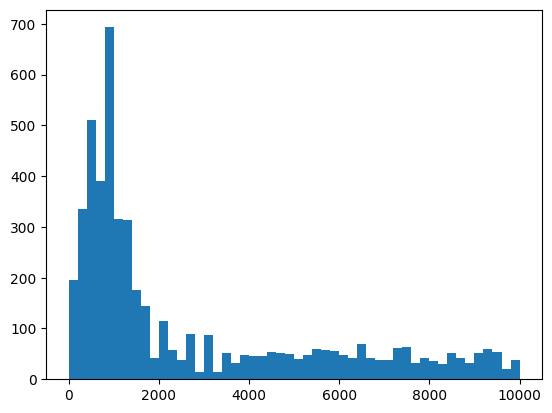

In [1340]:
# Looking at lower range--under 10,000

plt.hist(condo_lots.dropna(), bins=50, range=(1,10000))
plt.show()

In [1341]:
len(condos[condos['lotSize'] < 10000])

5041

In [1342]:
condos[condos['lotSize'] == 1]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSaleDate,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType
13581,"8247-Nw-108th-Ct,-Unit-2,-Doral,-FL-33178","8247 Nw 108th Ct, Unit 2, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849528,-80.371886,Condo,3,...,2024-03-26T00:00:00.000Z,525000,0,0,0,2,0,False,NaN,None
16593,"8432-Nw-107th-Ct,-Unit-11,-Doral,-FL-33178","8432 Nw 107th Ct, Unit 11, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,4,...,2024-03-28T00:00:00.000Z,540000,0,0,0,2,0,False,NaN,None
34603,"607-Verrocchio-Dr,-Nokomis,-FL-34275","607 Verrocchio Dr, Nokomis, FL 34275",Nokomis,FL,34275,Sarasota,27.165702,-82.468757,Condo,2,...,2024-04-15T00:00:00.000Z,294000,1,1,0,1,1,0,1.0,Water
41854,"523-Pine-Hollow-Cir,-Englewood,-FL-34223","523 Pine Hollow Cir, Englewood, FL 34223",Englewood,FL,34223,Sarasota,26.959838,-82.349775,Condo,2,...,2024-04-22T00:00:00.000Z,240000,1,1,0,1,1,0,1.0,Lake
42018,"1600-Sw-1st-Ave,-Apt-706,-Miami,-FL-33129","1600 Sw 1st Ave, Apt 706, Miami, FL 33129",Miami,FL,33129,Miami-Dade,25.759377,-80.197548,Condo,1,...,2024-04-23T00:00:00.000Z,465000,0,0,0,1,0,0,NaN,None
43684,"10775-Nw-83rd-Ter,-Unit-1,-Doral,-FL-33178","10775 Nw 83rd Ter, Unit 1, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,4,...,2024-04-24T00:00:00.000Z,560000,0,0,0,2,0,0,NaN,None
46242,"1100-S-Miami-Ave,-Apt-3904,-Miami,-FL-33130","1100 S Miami Ave, Apt 3904, Miami, FL 33130",Miami,FL,33130,Miami-Dade,25.763216,-80.193663,Condo,2,...,2024-04-26T00:00:00.000Z,640000,0,0,0,1,0,0,NaN,None
46549,"18555-Collins-Ave,-Apt-5505,-Sunny-Isles-Beach...","18555 Collins Ave, Apt 5505, Sunny Isles Beach...",Sunny Isles Beach,FL,33160,Miami-Dade,25.948150,-80.119947,Condo,3,...,2024-04-26T00:00:00.000Z,5572100,0,0,0,1,0,0,NaN,None
54145,"8244-Nw-107th-Path,-Unit-10,-Doral,-FL-33178","8244 Nw 107th Path, Unit 10, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,2,...,2024-05-03T00:00:00.000Z,390000,0,0,0,2,0,False,NaN,None
69451,"8501-Nw-107th-Ct,-Unit-3,-Doral,-FL-33178","8501 Nw 107th Ct, Unit 3, Doral, FL 33178",Doral,FL,33178,Miami-Dade,25.849533,-80.371880,Condo,2,...,2024-05-20T00:00:00.000Z,438000,0,0,0,2,0,False,NaN,None


Dealing with lot size--initial strategy:
- With viewType column, simplify all titles with golf in the name to one value
- Search the subdivision column for the word golf and use it to alter the viewType column
- Drop large lot size values that don't have the word golf
- For properties without golf, assign the mean of the lower quartile to all lot sizes

In [1343]:
data['viewType'].value_counts()

viewType
Water                                              2075
Average                                            1253
Golf Course                                         515
Lake                                                205
Park                                                135
River                                                77
Lake / Pond                                          60
Canal                                                11
Lake, Corner                                          9
City                                                  8
Waterfront / Beach, Corner                            8
Creek / Lake                                          7
Golf Course, Lake                                     7
Golf Course, Corner                                   6
Fairway                                               4
Waterfront / Canal, Corner                            3
Historical                                            3
Waterfront / Beachfront (Ocean, River, 

In [1344]:
golf_mapper = {
    'Golf Course':1,
    'Golf Course, Lake':1,
    'Golf Course, Corner':1,
    'Golf Course, Waterfront / Beach':1,
    'Lake, Golf Course':1
}

data['golf'] = data['viewType'].map(golf_mapper).fillna(0).astype(int)

In [1345]:
data['golf'].value_counts()

golf
0    112546
1       530
Name: count, dtype: int64

In [1346]:
data[data['subdivision'].str.contains('GOLF', case=False, na=False)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf
142,"210-Hazard-St,-Orlando,-FL-32804","210 Hazard St, Orlando, FL 32804",Orlando,FL,32804,Orange,28.587267,-81.380476,Single Family,2,...,375000,1,1,0,1,1,False,1.0,None,0
204,"5820-Nw-12th-St,-Apt-D,-Sunrise,-FL-33313","5820 Nw 12th St, Apt D, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.138610,-80.228350,Single Family,3,...,1220000,1,0,0,1,0,False,1.0,None,0
207,"6680-Nw-29th-Ct,-Sunrise,-FL-33313","6680 Nw 29th Ct, Sunrise, FL 33313",Sunrise,FL,33313,Broward,26.162295,-80.238154,Single Family,2,...,459000,1,0,0,1,1,False,1.0,None,0
232,"8608-Se-141st-Street-Rd,-Summerfield,-FL-34491","8608 Se 141st Street Rd, Summerfield, FL 34491",Summerfield,FL,34491,Marion,29.018361,-82.010480,Single Family,2,...,220000,1,1,0,1,1,False,1.0,None,0
242,"3189-Pebble-Beach-Dr,-Lake-Worth,-FL-33467","3189 Pebble Beach Dr, Lake Worth, FL 33467",Lake Worth,FL,33467,Palm Beach,26.629463,-80.173028,Single Family,3,...,615000,1,1,0,1,0,True,1.0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144369,"10030-Horse-Creek-Rd,-Fort-Myers,-FL-33913","10030 Horse Creek Rd, Fort Myers, FL 33913",Fort Myers,FL,33913,Lee,26.588741,-81.786486,Single Family,2,...,510000,1,1,0,1,1,True,1.0,None,0
144899,"836-Blue-Crane-Dr,-Venice,-FL-34285","836 Blue Crane Dr, Venice, FL 34285",Venice,FL,34285,Sarasota,27.083954,-82.412983,Single Family,3,...,820000,1,1,1,1,1,False,1.0,None,0
145021,"3801-Michaels-Landing-Cir-E,-Jacksonville,-FL-...","3801 Michaels Landing Cir E, Jacksonville, FL ...",Jacksonville,FL,32224,Duval,30.279827,-81.486056,Single Family,4,...,975000,1,1,1,2,1,False,1.0,None,0
145153,"4665-Bocaire-Blvd,-Boca-Raton,-FL-33487","4665 Bocaire Blvd, Boca Raton, FL 33487",Boca Raton,FL,33487,Palm Beach,26.419460,-80.115809,Single Family,3,...,1215000,1,1,0,1,1,True,1.0,Golf Course,1


In [1347]:
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8,...,27500000,0,0,0,1,0,False,NaN,None,0
1,"5018-Coquina-Key-Dr-SE,-Saint-Petersburg,-FL-3...","5018 Coquina Key Dr SE, Saint Petersburg, FL 3...",Saint Petersburg,FL,33705,Pinellas,27.722504,-82.627381,Townhouse,2,...,469000,0,0,0,2,0,True,1.0,Water,0
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3,...,170000,1,1,0,1,1,False,1.0,None,0
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2,...,300000,0,0,0,1,0,False,NaN,None,0
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2,...,250000,0,0,0,1,0,False,NaN,None,0


In [1348]:
data.loc[data['subdivision'].str.contains('GOLF', case=False, na=False), 'golf'] = 1
data['golf'].value_counts()

golf
0    111648
1      1428
Name: count, dtype: int64

In [1349]:
len(data[(data['lotSize'] > 43500) & (data['golf'] == 1) & (data['propertyType'] == 'Condo')])

60

In [1350]:
len(data[(data['lotSize'] > 43500) & (data['golf'] == 0) & (data['propertyType'] == 'Condo')])

4429

In [1351]:
len(data[(data['lotSize'] < 43500) & (data['golf'] == 1) & (data['propertyType'] == 'Condo')])

205

In [1352]:
len(data[data['propertyType'] == 'Condo'])

10722

There is a lot of variety in these. It may not make sense to drop them all--the large lot size values seem to sometimes correspond with amenities. The best approach may be to just take lot size out of the equation by making it 1. Does lot size correlate with price for condos?

In [1353]:
condos.shape

(10722, 25)

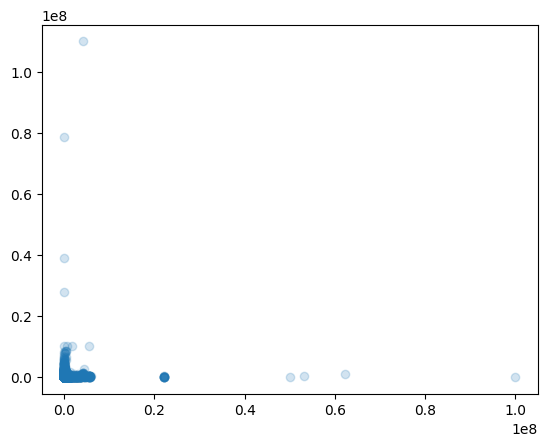

In [1354]:
plt.scatter(x=condos['lotSize'], y=condos['lastSalePrice'], alpha=0.2)
plt.show()

There is no apparent correlation. It might make the most sense to make lot size 0 and trust the location data to account for the price differences.

In [1355]:
# Assigning 0 to lotSize for all condos

data.loc[data["propertyType"] == "Condo", "lotSize"] = 0


In [1356]:
county_counts = data['county'].value_counts()
county_counts.head(60)

county
Palm Beach      7888
Lee             7456
Hillsborough    7389
Broward         7193
Orange          6223
Duval           6129
Miami-Dade      5934
Pinellas        5865
Polk            5646
Pasco           4879
Sarasota        3667
Volusia         3612
Brevard         3424
Marion          3366
Manatee         3358
Osceola         2936
Lake            2543
Charlotte       2434
Seminole        2359
Saint Johns     1916
Collier         1600
Saint Lucie     1558
Escambia        1234
Bay             1187
Flagler         1141
Clay            1140
Hernando        1126
Alachua         1063
Leon            1005
Okaloosa         985
Citrus           973
Indian River     761
Sumter           644
Martin           587
Walton           585
Highlands        526
St. Lucie        479
Nassau           435
Monroe           432
St. Johns        248
Santa Rosa       199
Putnam           172
Hendry           118
Wakulla           99
Columbia          77
Gulf              48
Okeechobee        44
Levy  

In [1357]:
# Creating column with average 30 year mortgage rates by month

data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

data['year_month'] = data['lastSaleDate'].dt.to_period('M')

m_rate = {
    '2024-03':0.0682,
    '2024-04':0.0699,
    '2024-05':0.076,
    '2024-06':0.0692,
    '2024-07':0.0685,
    '2024-08':0.065,
    '2024-09':0.0618,
    '2024-10':0.0643,
    '2024-11':0.0681,
    '2024-12':0.0672,
    '2025-01':0.0696,
    '2025-02':0.0684,
    '2025-03':0.0668
}

data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

data['m_rate'] = data['year_month'].map(m_rate)


/tmp/ipykernel_62958/117635043.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['lastSaleDate'].dt.to_period('M')


In [1358]:
data['year_month'].value_counts()

year_month
2024-04    24770
2024-05    24516
2024-06    20384
2024-07    16910
2024-03    14270
2024-08     2687
2024-10     2050
2024-09     1964
2024-11     1873
2024-12     1743
2025-01     1306
2025-02      598
2025-03        5
Name: count, dtype: int64

In [1359]:
data['m_rate']

0         0.0682
1         0.0682
2         0.0682
3         0.0682
4         0.0682
           ...  
145612    0.0692
145613    0.0692
145614    0.0692
145615    0.0692
145616    0.0692
Name: m_rate, Length: 113076, dtype: float64

In [1360]:
data['city'].value_counts()

city
Jacksonville             5745
Orlando                  3996
Tampa                    3604
Miami                    3150
Ocala                    2412
                         ... 
Saint Augustine South       1
Jupiter Inlet Colony        1
Key Colony                  1
La Crosse                   1
Ebro                        1
Name: count, Length: 529, dtype: int64

# EDA on sale prices

In [1361]:
data['lastSalePrice'].describe()

count    1.130760e+05
mean     5.585823e+05
std      1.753462e+06
min      3.100000e+02
25%      2.675000e+05
50%      3.750000e+05
75%      5.450000e+05
max      2.880000e+08
Name: lastSalePrice, dtype: float64

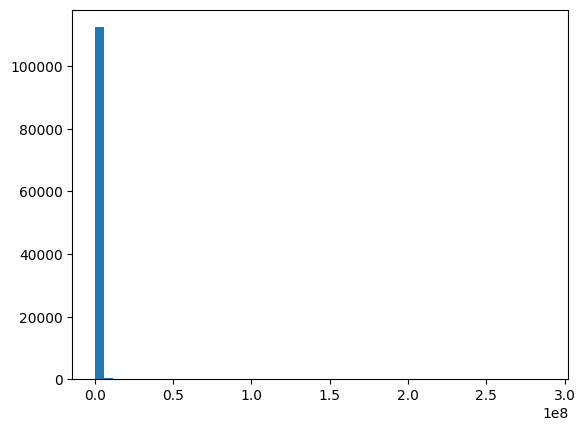

In [1362]:
plt.hist(data['lastSalePrice'], bins=50)
plt.show()

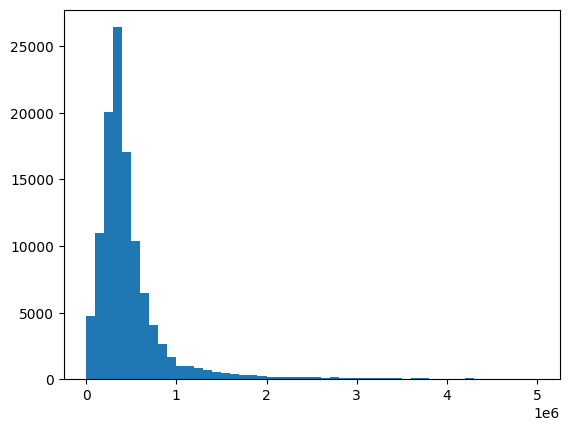

In [1363]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,5000000))
plt.show()


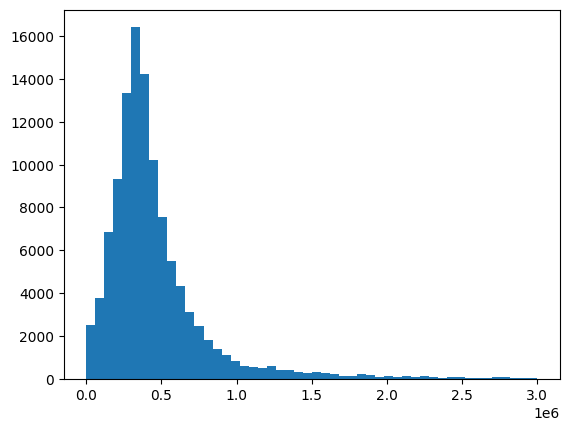

In [1364]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,3000000))
plt.show()

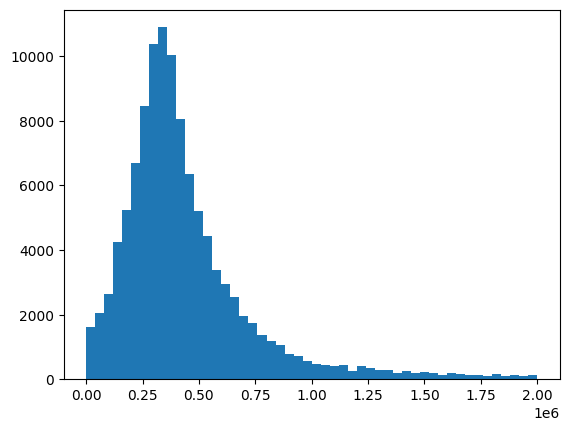

In [1365]:
plt.hist(data['lastSalePrice'], bins=50, range=(0,2000000))
plt.show()

# EDA on unitCount
This was done before dropping the column outright at the beginning

In [1366]:
data['unitCount'].describe()

count    85295.000000
mean         1.048643
std          2.637112
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        571.000000
Name: unitCount, dtype: float64

Massive range of values, but the majority of properties are single unit.

# EDA on propertyType

In [1367]:
data['propertyType'].value_counts()

propertyType
Single Family    90451
Condo            10722
Land              4771
Manufactured      3336
Multi-Family      2151
Townhouse         1373
Apartment          272
Name: count, dtype: int64

Most properties are condo or single family.

In [1368]:
# Looking at propertyType --> Land

land = data[data['propertyType'] == 'Land']
land.shape

(4771, 28)

In [1369]:
land.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,golf,m_rate
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4.771000e+03,4771.000000,4.771000e+03,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,431.000000,4771.000000,4771.000000
mean,28.001660,-81.869891,3.402641,2.274576,1949.923077,1.015979e+04,2016.770069,6.416363e+05,0.087822,0.089289,0.017606,1.013414,0.052610,1.095128,0.003563,0.070603
std,1.043554,0.878672,0.891084,0.678558,678.463566,4.762589e+04,21.741703,1.816363e+06,0.283066,0.285191,0.131530,0.116861,0.223276,0.600581,0.059592,0.003144
min,24.554356,-87.436596,1.000000,1.000000,100.000000,4.000000e+00,1700.000000,5.100000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.061800
25%,27.285458,-82.291246,3.000000,2.000000,1566.000000,4.522500e+03,2023.000000,3.292000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.068500
50%,28.154993,-81.777624,3.000000,2.000000,1828.000000,6.250000e+03,2024.000000,3.965000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.069200
75%,28.436959,-81.500640,4.000000,3.000000,2217.000000,8.955500e+03,2024.000000,5.191500e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.069900
max,30.968808,-80.037905,12.000000,9.000000,11456.000000,2.165803e+06,2027.000000,6.250000e+07,1.000000,1.000000,1.000000,3.000000,1.000000,9.000000,1.000000,0.076000


In [1370]:
# Range of values for Land

# plt.scatter(x=land.id, y=land.lastSalePrice)
# plt.show()

Assuming this property type is empty land on which to build, there are a surprsing number of bedrooms, bathrooms, etc. 

Rows with this property type may need to be dropped from the model.

In [1371]:
# Looking at propertyType --> Manufactured

manufactured = data[data['propertyType'] == 'Manufactured']
manufactured.shape

(3336, 28)

In [1372]:
manufactured.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,golf,m_rate
count,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000,3.336000e+03,3336.000000,3.336000e+03,3336.000000,3336.000000,3336.000000,3336.000000,3336.000000,2881.000000,3336.000000,3336.000000
mean,28.222530,-81.969870,2.436151,1.793165,1147.934353,3.160327e+04,1987.324940,1.799045e+05,0.729317,0.723621,0.079436,1.002398,0.584832,1.003471,0.010791,0.070247
std,1.202976,1.064719,0.722813,0.459217,415.912489,1.929626e+05,14.655911,4.332670e+05,0.444379,0.447273,0.270459,0.048919,0.492825,0.074455,0.103335,0.003382
min,24.566139,-87.510107,1.000000,1.000000,200.000000,1.000000e+00,1900.000000,6.000000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.061800
25%,27.468592,-82.375857,2.000000,2.000000,853.500000,4.795500e+03,1977.000000,9.900000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.068500
50%,28.221854,-81.943932,2.000000,2.000000,1125.000000,7.328500e+03,1986.000000,1.500000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.069200
75%,28.958932,-81.565505,3.000000,2.000000,1404.000000,1.725750e+04,1997.000000,2.100000e+05,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.069900
max,30.946223,-80.060530,7.000000,4.000000,4680.000000,5.462023e+06,2025.000000,2.250000e+07,1.000000,1.000000,1.000000,2.000000,1.000000,4.000000,1.000000,0.076000


In [1373]:
# It looks like this is mostly single units, but the max is 5,000 for units

manufactured['unitCount'].value_counts()

unitCount
1.0    2873
2.0       7
4.0       1
Name: count, dtype: int64

In [1374]:
# Looking at the outlier

manufactured[manufactured['unitCount'] == 5000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate


From checking Zillow on this address, this is an entire condo complex--probably outside the scope of the project.

What are the single-unit properties in this category like?

In [1375]:
manufactured = manufactured[manufactured['unitCount'] == 1.0]
manufactured.head(25)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
67,"8709-S-Meadowview-Cir,-Tampa,-FL-33625","8709 S Meadowview Cir, Tampa, FL 33625",Tampa,FL,33625,Hillsborough,28.053556,-82.577342,Manufactured,2,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682
97,"3141-Old-Farm-House-Dr,-North-Fort-Myers,-FL-3...","3141 Old Farm House Dr, North Fort Myers, FL 3...",North Fort Myers,FL,33917,Lee,26.709915,-81.895790,Manufactured,2,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682
98,"128-Torch-Ln,-North-Fort-Myers,-FL-33917","128 Torch Ln, North Fort Myers, FL 33917",North Fort Myers,FL,33917,Lee,26.692646,-81.859562,Manufactured,2,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682
137,"16-Golden-Gate-Cir,-Port-Orange,-FL-32129","16 Golden Gate Cir, Port Orange, FL 32129",Port Orange,FL,32129,Volusia,29.136491,-81.017564,Manufactured,3,...,1,1,1,1,False,1.0,None,0,2024-03,0.0682
296,"1100-Belcher-Rd-S,-Lot-371,-Largo,-FL-33771","1100 Belcher Rd S, Lot 371, Largo, FL 33771",Largo,FL,33771,Pinellas,27.905466,-82.750327,Manufactured,2,...,1,0,1,1,True,1.0,None,0,2024-03,0.0682
323,"207-E-Harris-St,-Palatka,-FL-32177","207 E Harris St, Palatka, FL 32177",Palatka,FL,32177,Putnam,29.660439,-81.653605,Manufactured,3,...,0,0,1,0,False,1.0,None,0,2024-03,0.0682
471,"220-El-Prado-Pl,-Panama-City-Beach,-FL-32413","220 El Prado Pl, Panama City Beach, FL 32413",Panama City Beach,FL,32413,Bay,30.243290,-85.924014,Manufactured,3,...,1,0,1,0,False,1.0,None,0,2024-03,0.0682
477,"457-Citrus-Ridge-Dr,-Davenport,-FL-33837","457 Citrus Ridge Dr, Davenport, FL 33837",Davenport,FL,33837,Polk,28.212509,-81.629595,Manufactured,2,...,0,0,1,1,False,1.0,None,0,2024-03,0.0682
578,"304-48th-Avenue-Dr-W,-Bradenton,-FL-34207","304 48th Avenue Dr W, Bradenton, FL 34207",Bradenton,FL,34207,Manatee,27.455909,-82.565993,Manufactured,3,...,0,0,1,1,False,1.0,None,0,2024-03,0.0682
579,"224-Westwood-Dr,-Leesburg,-FL-34748","224 Westwood Dr, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.823214,-81.949367,Manufactured,2,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682


Looking at some of these on Zillow, they seem to be mostly mobile homes with a few single family homes mixed in. 

This category may be fine for the model.

# EDA on multiFamily

In [1376]:
multiFamily = data[data['propertyType'] == 'Multi-Family']
multiFamily.shape

(2151, 28)

In [1377]:
multiFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2151 entries, 26 to 145609
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                2151 non-null   object             
 1   formattedAddress  2151 non-null   object             
 2   city              2151 non-null   object             
 3   state             2151 non-null   object             
 4   zipCode           2151 non-null   object             
 5   county            2151 non-null   object             
 6   latitude          2151 non-null   float64            
 7   longitude         2151 non-null   float64            
 8   propertyType      2151 non-null   object             
 9   bedrooms          2151 non-null   int64              
 10  bathrooms         2151 non-null   int64              
 11  squareFootage     2151 non-null   int64              
 12  lotSize           2151 non-null   int64              
 13  yearB

In [1378]:
# Looking at range of sale values

# plt.scatter(x=multiFamily.id, y=multiFamily.lastSalePrice)
# plt.show()

In [1379]:
# What are the 100000000+ million dollar places, and the other outliers over 20,000,000?

multiFamily[multiFamily.lastSalePrice > 20000000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
1339,"1809-Jackson-St,-Unit-619,-Hollywood,-FL-33020","1809 Jackson St, Unit 619, Hollywood, FL 33020",Hollywood,FL,33020,Broward,26.008930,-80.143410,Multi-Family,2,...,0,0,12,1,False,NaN,None,0,2024-03,0.0682
15217,"3317-Broadway,-West-Palm-Beach,-FL-33407","3317 Broadway, West Palm Beach, FL 33407",West Palm Beach,FL,33407,Palm Beach,26.743198,-80.056935,Multi-Family,6,...,1,0,2,1,False,NaN,None,0,2024-03,0.0682
63068,"1345-W-28th-St,-Apt-2,-Hialeah,-FL-33010","1345 W 28th St, Apt 2, Hialeah, FL 33010",Hialeah,FL,33010,Miami-Dade,25.847361,-80.309305,Multi-Family,2,...,0,0,1,0,False,NaN,None,0,2024-05,0.0760
104642,"1495-Spring-Harbor-Dr,-Delray-Beach,-FL-33445","1495 Spring Harbor Dr, Delray Beach, FL 33445",Delray Beach,FL,33445,Palm Beach,26.437936,-80.092683,Multi-Family,1,...,0,0,1,0,False,NaN,None,0,2024-07,0.0685
128826,"7960-Pine-Crossings-Cir,-Orlando,-FL-32807","7960 Pine Crossings Cir, Orlando, FL 32807",Orlando,FL,32807,Orange,28.545065,-81.280277,Multi-Family,2,...,1,1,2,1,True,14.0,None,0,2024-09,0.0618


From Zillow research, these seem to be either large apartment buildings or innacurate records.

In [1380]:
# Looking at the 10 to 20 million range

multiFamily[(multiFamily.lastSalePrice < 20000000) & (multiFamily.lastSalePrice > 10000000)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
74569,"11900-Nw-19th-Ave,-Miami,-FL-33167","11900 Nw 19th Ave, Miami, FL 33167",Miami,FL,33167,Miami-Dade,25.883316,-80.231757,Multi-Family,128,...,0,0,2,1,False,3.0,None,1,2024-05,0.0760
125950,"243-Ne-12th-Ave,-Homestead,-FL-33030","243 Ne 12th Ave, Homestead, FL 33030",Homestead,FL,33030,Miami-Dade,25.472529,-80.460070,Multi-Family,62,...,0,0,2,0,False,10.0,None,0,2024-08,0.0650
133318,"3681-Sw-60th-Ter,-Apt-4,-Davie,-FL-33314","3681 Sw 60th Ter, Apt 4, Davie, FL 33314",Davie,FL,33314,Broward,26.076095,-80.227879,Multi-Family,6,...,0,0,2,0,0,4.0,None,0,2024-11,0.0681
137460,"14555-Ne-6th-Ave,-Unit-106,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 106, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1,...,0,0,1,0,0,NaN,None,0,2024-12,0.0672
137464,"14555-Ne-6th-Ave,-Unit-225,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 225, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1,...,0,0,1,0,0,NaN,None,0,2024-12,0.0672
137466,"14555-Ne-6th-Ave,-Unit-105,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 105, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1,...,0,0,1,0,0,NaN,None,0,2024-12,0.0672


There is a combination of full apartment buildings and individual units. 

Recommend dropping this category--outside of the scope of a web app for home buyers and likely to misinform the model.

# EDA on Townhouse

In [1381]:
townhouse = data[data['propertyType'] == 'Townhouse']
townhouse.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 1 to 145450
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                1373 non-null   object             
 1   formattedAddress  1373 non-null   object             
 2   city              1373 non-null   object             
 3   state             1373 non-null   object             
 4   zipCode           1373 non-null   object             
 5   county            1368 non-null   object             
 6   latitude          1373 non-null   float64            
 7   longitude         1373 non-null   float64            
 8   propertyType      1373 non-null   object             
 9   bedrooms          1373 non-null   int64              
 10  bathrooms         1373 non-null   int64              
 11  squareFootage     1373 non-null   int64              
 12  lotSize           1373 non-null   int64              
 13  yearBu

In [1382]:
townhouse.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,golf,m_rate
count,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1.373000e+03,1373.000000,1.373000e+03,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,631.000000,1373.000000,1373.000000
mean,27.876338,-81.553724,2.750910,2.091770,1578.533867,5.157304e+04,2005.232338,6.182023e+05,0.382374,0.346686,0.038602,1.395484,0.327021,1.175911,0.005098,0.068371
std,1.434846,1.443995,0.653992,0.557507,603.376753,1.062923e+06,17.930236,1.656982e+06,0.486144,0.476088,0.192714,0.540119,0.469296,3.562475,0.071246,0.003634
min,24.552934,-87.444341,1.000000,1.000000,606.000000,5.900000e+01,1900.000000,4.100000e+02,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.061800
25%,26.565251,-82.272519,2.000000,2.000000,1291.000000,1.742000e+03,1987.000000,2.500000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.067200
50%,28.044241,-81.476957,3.000000,2.000000,1530.000000,2.221000e+03,2007.000000,3.360000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.068400
75%,28.548937,-80.325421,3.000000,2.000000,1763.000000,3.620000e+03,2023.000000,4.750000e+05,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.069600
max,30.956392,-80.039679,6.000000,9.000000,16783.000000,3.794076e+07,2026.000000,3.571429e+07,1.000000,1.000000,1.000000,4.000000,1.000000,90.000000,1.000000,0.076000


Nothing here seems too unusual, aside from max yearBuilt is 2026--will investigate that whole column. This category may be fine to use.

# EDA on Apartment

In [1383]:
apt = data[data['propertyType'] == 'Apartment']
apt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 1291 to 145394
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                272 non-null    object             
 1   formattedAddress  272 non-null    object             
 2   city              272 non-null    object             
 3   state             272 non-null    object             
 4   zipCode           272 non-null    object             
 5   county            272 non-null    object             
 6   latitude          272 non-null    float64            
 7   longitude         272 non-null    float64            
 8   propertyType      272 non-null    object             
 9   bedrooms          272 non-null    int64              
 10  bathrooms         272 non-null    int64              
 11  squareFootage     272 non-null    int64              
 12  lotSize           272 non-null    int64              
 13  year

In [1384]:
apt.describe()

,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,cooling,heating,fireplace,floorCount,garage,unitCount,golf,m_rate
count,272.000000,272.000000,272.000000,272.000000,272.000000,2.720000e+02,272.000000,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,99.000000,272.000000,272.000000
mean,27.297650,-81.154849,5.011029,2.426471,2711.422794,7.867716e+05,1971.878676,2.784055e+06,0.301471,0.253676,0.022059,1.102941,0.161765,9.040404,0.003676,0.068540
std,1.408218,1.231652,43.684670,8.537854,11453.164461,1.217382e+07,27.131292,1.072133e+07,0.459742,0.435917,0.147146,0.370088,0.368914,42.817105,0.060634,0.003739
min,25.460572,-87.314542,0.000000,1.000000,100.000000,2.500000e+01,1700.000000,6.000000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.061800
25%,26.020741,-81.860162,1.000000,1.000000,688.000000,6.324250e+03,1959.000000,2.567500e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.067200
50%,26.846028,-80.671003,2.000000,1.000000,958.000000,1.032000e+04,1972.000000,6.500000e+05,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.068500
75%,28.351808,-80.185806,2.000000,2.000000,1802.000000,2.352200e+04,1982.250000,1.327603e+06,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.069600
max,30.433831,-80.035977,720.000000,127.000000,178877.000000,2.008116e+08,2024.000000,1.392500e+08,1.000000,1.000000,1.000000,5.000000,1.000000,352.000000,1.000000,0.076000


In [1385]:
# Looking at a few of the 2 bedroom to check on Zillow

# Need to double check this one

apt[apt['bedrooms'] == 2].head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
1872,"200-S-11th-St,-Ste-103,-Leesburg,-FL-34748","200 S 11th St, Ste 103, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.809777,-81.882210,Apartment,2,...,1,0,2,0,False,NaN,None,0,2024-03,0.0682
2705,"1514-Sw-6th-St,-Apt-4,-Miami,-FL-33135","1514 Sw 6th St, Apt 4, Miami, FL 33135",Miami,FL,33135,Miami-Dade,25.767258,-80.219963,Apartment,2,...,0,0,1,0,False,NaN,None,0,2024-03,0.0682
4289,"504-Chelsee-Way,-Lake-Placid,-FL-33852","504 Chelsee Way, Lake Placid, FL 33852",Lake Placid,FL,33852,Highlands,27.241486,-81.330743,Apartment,2,...,1,0,1,0,False,2.0,None,0,2024-03,0.0682
5841,"102-Fountain-Cv,-Leesburg,-FL-34748","102 Fountain Cv, Leesburg, FL 34748",Leesburg,FL,34748,Lake,28.757426,-81.869895,Apartment,2,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682
9532,"681-Lake-June-Rd,-Lake-Placid,-FL-33852","681 Lake June Rd, Lake Placid, FL 33852",Lake Placid,FL,33852,Highlands,27.324927,-81.395411,Apartment,2,...,0,0,1,0,False,NaN,None,0,2024-03,0.0682


These are an inconsistent mixture of rental properties and large multi-unit buidlings--recommend dropping category from model.

Overall recommendation on propertyType: limit to single-family, condo, manufactured, and townhouse.

# EDA on yearBuilt

Does year build have a clear relationship to sale price?

In [1386]:
years = data['yearBuilt']

years.info()



<class 'pandas.core.series.Series'>
Index: 113076 entries, 0 to 145616
Series name: yearBuilt
Non-Null Count   Dtype
--------------   -----
113076 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


Fairly large number of nulls, and this column likely cannot be imputed. Either the null rows should be dropped or the entire column, depending on how much it seems to correlate to price.

In [1387]:
years

0         2028
1         1979
2         1951
3         1965
4         1986
          ... 
145612    2002
145613    2024
145614    1947
145615    2024
145616    2024
Name: yearBuilt, Length: 113076, dtype: int64

In [1388]:
years.describe()

count    113076.000000
mean       1991.513097
std          25.222033
min         202.000000
25%        1974.000000
50%        1993.000000
75%        2014.000000
max        2028.000000
Name: yearBuilt, dtype: float64

In [1389]:
# The min is 202--investigating further

data[data['yearBuilt'] == 202]



,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
121788,"4451-Sw-170th-Street-Rd,-Ocala,-FL-34473","4451 Sw 170th Street Rd, Ocala, FL 34473",Ocala,FL,34473,Marion,28.974421,-82.195729,Single Family,3,...,0,0,1,0,False,NaN,None,0,2024-07,0.0685


In [1390]:
# Filling in year from Zillow

data.loc[121788, 'yearBuilt'] = 2023

In [1391]:
print(years.unique())

[2028 1979 1951 1965 1986 2014 2010 1989 1958 1981 1999 1950 1953 2018
 1998 1957 2005 1960 2006 1987 2002 1964 1980 1969 1975 1962 1954 1952
 1945 2009 2000 1977 1971 2004 1955 1946 1947 1956 2025 1914 2007 1997
 1925 2003 1985 1995 1968 1983 1993 2017 1990 1941 1984 1978 1949 2021
 1994 1930 1991 2001 1967 2026 1982 2019 2016 2024 1972 1966 1973 1974
 2020 2011 1948 1940 1996 1961 2012 1988 2022 2023 1939 1963 1976 1959
 1992 2008 1942 2015 1935 1905 2013 1927 1970 1917 1938 1900 1929 1932
 1928 1937 1909 1931 1926 1924 1944 1923 1921 1943 1910 1822 1901 1936
 1918 1920 1913 1933 1922 1885 1916 1919 1915 1908 1934 1906 1912 1891
 1894 1902 1903 1889 1884 1893 1841 1911 1890 1700 1882 1907 1904 1881
 1892 1895 1898 1865 2027]


In [1392]:
# The max is 2028--investigating this row

data.iloc[data['yearBuilt'].idxmax()]

id                  1960-S-Ocean-Blvd,-Manalapan,-FL-33462
formattedAddress    1960 S Ocean Blvd, Manalapan, FL 33462
city                                             Manalapan
state                                                   FL
zipCode                                              33462
county                                          Palm Beach
latitude                                         26.551645
longitude                                       -80.042184
propertyType                                 Single Family
bedrooms                                                 8
bathrooms                                               12
squareFootage                                        50000
lotSize                                             171038
yearBuilt                                             2028
subdivision                                           None
lastSaleDate                     2024-03-12 00:00:00+00:00
lastSalePrice                                     275000

In [1393]:
# Are there other homes with questionable yearBuilt?

data[(data['yearBuilt'] >= 2026) & (data['yearBuilt'] <= 2028)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8,...,0,0,1,0,False,NaN,None,0,2024-03,0.0682
95,"12404-Indian-Rd,-North-Palm-Beach,-FL-33408","12404 Indian Rd, North Palm Beach, FL 33408",North Palm Beach,FL,33408,Palm Beach,26.857967,-80.050201,Land,6,...,1,1,1,1,True,1.0,Water,0,2024-03,0.0682
267,"145-Nw-9th-St,-Boca-Raton,-FL-33432","145 Nw 9th St, Boca Raton, FL 33432",Boca Raton,FL,33432,Palm Beach,26.358732,-80.088873,Single Family,5,...,1,0,1,1,False,1.0,None,0,2024-03,0.0682
10070,"10670-Sw-26th-Ct,-Davie,-FL-33328","10670 Sw 26th Ct, Davie, FL 33328",Davie,FL,33328,Broward,26.087203,-80.290948,Single Family,7,...,0,0,1,1,False,1.0,None,0,2024-03,0.0682
14045,"303-N-Riverside-Dr,-Indialantic,-FL-32903","303 N Riverside Dr, Indialantic, FL 32903",Indialantic,FL,32903,Brevard,28.090759,-80.575606,Townhouse,3,...,1,1,1,1,False,1.0,None,0,2024-03,0.0682
46028,"939-Eve-St,-Delray-Beach,-FL-33483","939 Eve St, Delray Beach, FL 33483",Delray Beach,FL,33483,Palm Beach,26.438058,-80.067800,Single Family,6,...,1,0,1,1,1,1.0,Water,0,2024-04,0.0699
55187,"910-N-Venetian-Dr,-Miami-Beach,-FL-33139","910 N Venetian Dr, Miami Beach, FL 33139",Miami Beach,FL,33139,Miami-Dade,25.790402,-80.176450,Single Family,5,...,0,0,1,0,False,1.0,None,0,2024-05,0.0760
98992,"3929-Belmont-St,-Fort-Myers,-FL-33916","3929 Belmont St, Fort Myers, FL 33916",Fort Myers,FL,33916,Lee,26.657848,-81.833645,Single Family,4,...,0,0,1,0,0,NaN,None,0,2024-06,0.0692
125767,"2267-Windsor-Rd,-Palm-Beach-Gardens,-FL-33410","2267 Windsor Rd, Palm Beach Gardens, FL 33410",Palm Beach Gardens,FL,33410,Palm Beach,26.870753,-80.067382,Single Family,5,...,0,0,1,0,False,NaN,None,0,2024-08,0.0650
126074,"Eve-Cir,-Santa-Rosa-Beach,-FL-32459","Eve Cir, Santa Rosa Beach, FL 32459",Santa Rosa Beach,FL,32459,Walton,30.371818,-86.108500,Single Family,5,...,0,0,1,0,False,NaN,None,0,2024-08,0.0650


These appear to be projected builds. Leaving these rows seems fine.

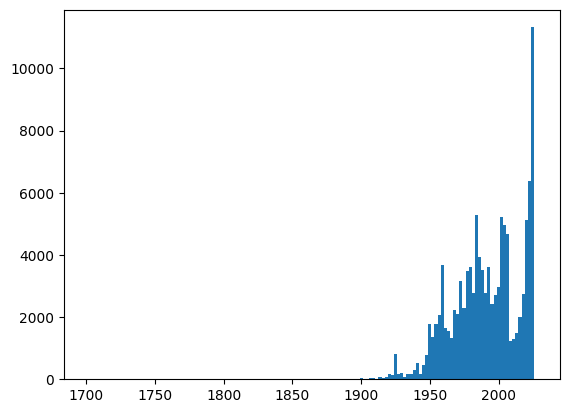

In [1394]:
plt.hist(data['yearBuilt'], bins=145)
plt.show()

In [1395]:
years.value_counts()

yearBuilt
2024    10016
2023     4406
2006     2935
2005     2746
2004     2218
        ...  
1892        1
1895        1
1898        1
1865        1
2027        1
Name: count, Length: 145, dtype: int64

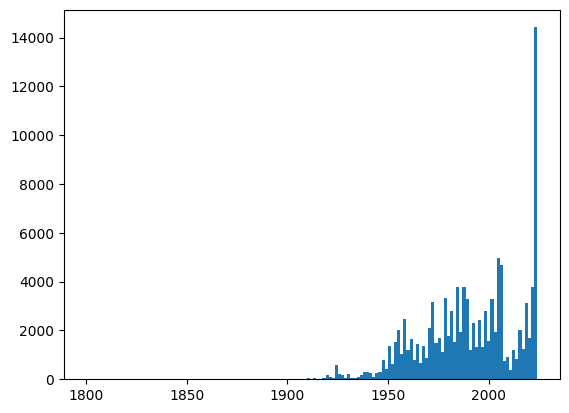

In [1396]:
plt.hist(data['yearBuilt'], bins=145, range=(1800,2024))
plt.show()

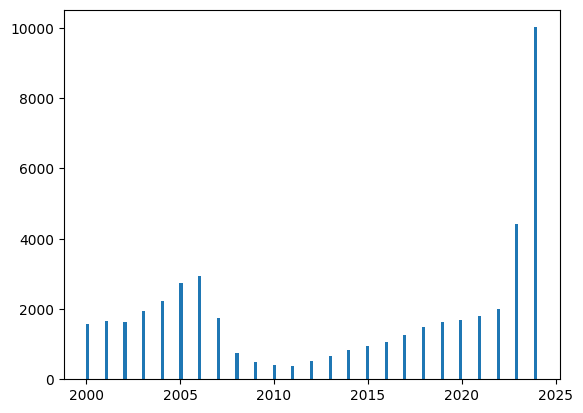

In [1397]:
plt.hist(data['yearBuilt'], bins=145, range=(2000,2024))
plt.show()

A few from the 19th C, some from first half 20th, most from 2024. 

# Effect of pool on price

In [1398]:
data['pool'].value_counts()

pool
False           82973
0               17688
True            10401
1                1996
Type Unknown        9
Inground            8
Pool/spa            1
Name: count, dtype: int64

In [1399]:
data[data['pool'] == 'Type Unknown']

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,heating,fireplace,floorCount,garage,pool,unitCount,viewType,golf,year_month,m_rate
11307,"1221-Biarritz-Dr,-Miami-Beach,-FL-33141","1221 Biarritz Dr, Miami Beach, FL 33141",Miami Beach,FL,33141,Miami-Dade,25.853754,-80.132029,Single Family,4,...,0,0,1,0,Type Unknown,1.0,None,0,2024-03,0.0682
18186,"6300-S-Pointe-Blvd,-Apt-201,-Fort-Myers,-FL-33919","6300 S Pointe Blvd, Apt 201, Fort Myers, FL 33919",Fort Myers,FL,33919,Lee,26.552392,-81.904911,Condo,2,...,1,0,1,1,Type Unknown,1.0,Street,0,2024-03,0.0682
21209,"358-Ne-Genesee-Ave,-Port-Saint-Lucie,-FL-34983","358 Ne Genesee Ave, Port Saint Lucie, FL 34983",Port Saint Lucie,FL,34983,St. Lucie,27.335812,-80.341880,Single Family,3,...,1,0,1,1,Type Unknown,1.0,None,0,2024-04,0.0699
32705,"3012-Brougham-Ave,-Jacksonville,-FL-32246","3012 Brougham Ave, Jacksonville, FL 32246",Jacksonville,FL,32246,Duval,30.291696,-81.464783,Single Family,3,...,1,0,1,1,Type Unknown,1.0,None,0,2024-04,0.0699
57747,"1767-Oak-Pond-Ct,-Oldsmar,-FL-34677","1767 Oak Pond Ct, Oldsmar, FL 34677",Oldsmar,FL,34677,Pinellas,28.038162,-82.687592,Single Family,4,...,1,0,2,1,Type Unknown,1.0,None,0,2024-05,0.0760
61879,"3761-Sw-1st-St,-Fort-Lauderdale,-FL-33312","3761 Sw 1st St, Fort Lauderdale, FL 33312",Fort Lauderdale,FL,33312,Broward,26.119984,-80.198751,Single Family,4,...,0,0,1,0,Type Unknown,1.0,None,0,2024-05,0.0760
81257,"721-Ne-137th-St,-North-Miami,-FL-33161","721 Ne 137th St, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.901596,-80.184257,Single Family,3,...,0,0,1,0,Type Unknown,1.0,None,0,2024-05,0.0760
103662,"7907-11th-Ave-NW,-Bradenton,-FL-34209","7907 11th Ave NW, Bradenton, FL 34209",Bradenton,FL,34209,Manatee,27.509208,-82.641532,Single Family,3,...,1,1,1,1,Type Unknown,1.0,None,0,2024-07,0.0685
121900,"810-Se-5th-Ter,-Pompano-Beach,-FL-33060","810 Se 5th Ter, Pompano Beach, FL 33060",Pompano Beach,FL,33060,Broward,26.219815,-80.114229,Single Family,3,...,0,0,1,1,Type Unknown,1.0,None,0,2024-07,0.0685


In [1400]:
# Checked on Zillow/Google for pools in the Type Unknown category--all but one have pools. Assigning 0 to that one.

data.loc[18186, 'pool'] = 0

In [1401]:
data.iloc[18186]

id                  3901-Ne-21st-Ave,-Apt-1,-Fort-Lauderdale,-FL-3...
formattedAddress    3901 Ne 21st Ave, Apt 1, Fort Lauderdale, FL 3...
city                                                  Fort Lauderdale
state                                                              FL
zipCode                                                         33308
county                                                        Broward
latitude                                                     26.17686
longitude                                                  -80.118583
propertyType                                             Multi-Family
bedrooms                                                           10
bathrooms                                                          10
squareFootage                                                    5750
lotSize                                                         10866
yearBuilt                                                        1966
subdivision         

In [1402]:
# Fixing pool column

bool_mapper = {
    '1':1,
    '0':0,
    'True':1,
    'False':0,
    'Inground':1,
    'Type Unknown': 1,
    'Pool/spa':1
}

data['pool'] = data['pool'].map(bool_mapper).fillna(0).astype(int)

In [1403]:
data['pool'].head()

0    0
1    1
2    0
3    0
4    0
Name: pool, dtype: int64

In [1404]:
data['pool'].isna().any()

np.False_

In [1405]:
# Choosing Jacksonville as the largest city, how does having a pool relate to sale price? 

jacksonville = data[data['city'] == 'Jacksonville']
jacksonville.shape

(5745, 28)

In [1406]:
jacksonville['pool'].value_counts()

pool
0    5455
1     290
Name: count, dtype: int64

In [1407]:
# Overlapping histograms for pool and no pool

In [1408]:
jacksonville.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5745 entries, 2 to 145606
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                5745 non-null   object             
 1   formattedAddress  5745 non-null   object             
 2   city              5745 non-null   object             
 3   state             5745 non-null   object             
 4   zipCode           5745 non-null   object             
 5   county            5745 non-null   object             
 6   latitude          5745 non-null   float64            
 7   longitude         5745 non-null   float64            
 8   propertyType      5745 non-null   object             
 9   bedrooms          5745 non-null   int64              
 10  bathrooms         5745 non-null   int64              
 11  squareFootage     5745 non-null   int64              
 12  lotSize           5745 non-null   int64              
 13  yearBu

# Modeling

In [1409]:
data['county'].value_counts().head(60)

county
Palm Beach      7888
Lee             7456
Hillsborough    7389
Broward         7193
Orange          6223
Duval           6129
Miami-Dade      5934
Pinellas        5865
Polk            5646
Pasco           4879
Sarasota        3667
Volusia         3612
Brevard         3424
Marion          3366
Manatee         3358
Osceola         2936
Lake            2543
Charlotte       2434
Seminole        2359
Saint Johns     1916
Collier         1600
Saint Lucie     1558
Escambia        1234
Bay             1187
Flagler         1141
Clay            1140
Hernando        1126
Alachua         1063
Leon            1005
Okaloosa         985
Citrus           973
Indian River     761
Sumter           644
Martin           587
Walton           585
Highlands        526
St. Lucie        479
Nassau           435
Monroe           432
St. Johns        248
Santa Rosa       199
Putnam           172
Hendry           118
Wakulla           99
Columbia          77
Gulf              48
Okeechobee        44
Levy  

In [1410]:
# Filtering to three counties in southeast

filtered = data[(data['county'] == 'Miami Dade') | (data['county'] == 'Broward') | (data['county'] == 'Palm Beach')]
filtered.shape

(15081, 28)

In [1411]:
data.city.value_counts().head(10)

city
Jacksonville        5745
Orlando             3996
Tampa               3604
Miami               3150
Ocala               2412
Cape Coral          2377
Kissimmee           2327
Saint Petersburg    2093
Fort Myers          2054
Bradenton           1775
Name: count, dtype: int64

In [1412]:
city_counts = data.city.value_counts()
big_cities = city_counts[city_counts >= 1775].index

filtered = data[data.city.isin(big_cities)]

filtered.shape

(29533, 28)

In [1413]:
property_types = ['Single Family','Condo']#,'Manufactured','Townhouse']
filtered = filtered[filtered['propertyType'].isin(property_types)]
filtered['propertyType'].value_counts()

propertyType
Single Family    23724
Condo             3177
Name: count, dtype: int64

In [1414]:
num_var = ['bedrooms','bathrooms','squareFootage','lotSize','pool','m_rate','cooling','heating','fireplace','garage','latitude','longitude','floorCount','lastSalePrice','yearBuilt']

model_var = ['zipCode','latitude','longitude','propertyType','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice','pool','m_rate','cooling','heating','fireplace','garage','floorCount','yearBuilt']

filtered = filtered[model_var]
filtered.shape

(26901, 17)

In [1415]:
# Setting range of home values

filtered = filtered[(filtered['lastSalePrice'] < 1000000) & (filtered['lastSalePrice'] > 10000)]

In [1416]:
# Getting dummies for cat_var

cat_var = ['propertyType','zipCode']

cat_data = pd.get_dummies(filtered[cat_var])

# Recreating the dataframe with the numerical and dummy columns 

filtered = pd.concat([filtered[num_var], cat_data], axis=1)

In [1417]:
# Getting columns for dummy variables

cat_var = cat_data.columns.astype(str).tolist()

In [1418]:
# Features and target, splitting data, scaling

y = filtered['lastSalePrice']
X = filtered.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)

In [1419]:
# Scaling numerical data

num_var.remove('lastSalePrice')

X_train_num = X_train[num_var]
X_test_num = X_test[num_var]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train[num_var])
X_test_scaled = scaler.transform(X_test[num_var])

X_train_scaled = scaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_num.index, columns=X_train_num.columns)

X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_num.index, columns=X_test_num.columns.astype(str))

In [1420]:
# Reassembling the fully processed X sets

X_train_p = pd.concat([X_train_scaled, X_train[cat_var]], axis=1)
X_test_p = pd.concat([X_test_scaled, X_test[cat_var]], axis=1)

In [1421]:
# Linear Regression

model = LinearRegression()
model.fit(X_train_p, y_train)

y_pred = model.predict(X_test_p)

# print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 112103.07587839341
Coefficient of determination: 0.6463960387048386


In [1422]:
# Decision Tree Regressor

dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train_p, y_train)

y_pred = dt_regressor.predict(X_test_p)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 136837.57848454805
Coefficient of determination: 0.4731429156169906


In [1423]:
# Random Forest Regressor

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_p, y_train)

y_pred = rf_regressor.predict(X_test_p)

print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

RMSE: 98221.0784375864
Coefficient of determination: 0.7285489910086033


In [1424]:
y_test.mean()

np.float64(375949.9894464357)

In [1425]:
y_pred.mean()

np.float64(374460.13219319127)

In [1426]:
# # Define the model
# rf_model = RandomForestRegressor(random_state=42)

# # Define the hyperparameter grid
# param_grid = {
#     "n_estimators": [50, 100, 200],  
#     "max_depth": [10, 20, None],  
#     "min_samples_split": [2, 5, 10],  
#     "min_samples_leaf": [1, 2, 5],  
#     "max_features": ["sqrt", "log2", None]  
# }

# # Perform grid search
# grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train)

# # Print the best parameters
# print("Best Parameters:", grid_search.best_params_)


In [1427]:
X_train_p.shape

(20088, 219)

In [1428]:
# # Training on log price

# filtered_by_city['log_price'] = np.log1p(filtered_by_city['lastSalePrice'])

# X = filtered_by_city.drop(['lastSalePrice', 'log_price'], axis=1) 
# y = filtered_by_city['log_price']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestRegressor(random_state=42)
# model.fit(X_train, y_train)


In [1429]:
# y_pred = model.predict(X_test_p)

# # print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
# print(f"RMSE: {root_mean_squared_error(y_test, y_pred)}")
# print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

In [1430]:
# X_train.columns.tolist()